In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("./modules/") # for d3plus2

sys.path.append("./../Hidalgo_Haussmann") # for HH tools
from HH_tools import *

import d3plus2 as d3plus

import numpy as np

import geopandas as gpd

In [2]:
path = './data/disagg_struct_refs/sources/US/'
agglevel_titles = pd.read_csv(path+'agglevel_titles.csv')
area_titles = pd.read_csv(path+'area_titles.csv')
industry_titles = pd.read_csv(path+'industry_titles.csv')
industry_titles =  pd.DataFrame([['POPESTIMATE2010','Population']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)
industry_titles =  pd.DataFrame([['Cropland','Cropland'],
                                ['Desert','Desert'],
                                ['Grassland','Grassland'],
                                ['Other','Other'],
                                ['Woodland','Woodland'],
                                ['Urban','Urban'],
                                ['Water','Water']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)
industry_titles =  pd.DataFrame([['ALAND','Area'],
                                ['pop_dens','Population density']],
                                 columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)

In [3]:
# df_cnt = df.loc[df.agglvl_code == 76]
# df_msa = df.loc[df.agglvl_code == 46]
df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
df_msa = pd.read_csv('./data/naics_area_msa_02_07.csv', index_col=[0, 1])
df_stt = pd.read_csv('./data/naics_area_stt_02_07.csv', index_col=[0, 1])

In [4]:
# Drop the unclassified!
df_cnt = df_cnt.loc[~(df_cnt.index.get_level_values('industry_code') == 9999)]

### Population and land uses

In [5]:
# Add population
county_LU = pd.read_csv('./data/US_land_use/land_use_frac.csv', index_col=0)
county_LU.index = county_LU.index.astype(str).str.zfill(5)

In [6]:
# plt.hist(log10(county_LU['Woodland']).dropna(), 50)
# plt.show()

In [7]:
# Add population

county_pop = pd.read_csv('./data/co-est2017-alldata.csv', encoding = 'latin-1')
county_pop['area_fips'] = county_pop.STATE.astype(str).str.zfill(2) + county_pop.COUNTY.astype(str).str.zfill(3)

county_pop = county_pop[['area_fips', 'POPESTIMATE2010']].set_index('area_fips')

In [8]:
# county_ = gpd.read_file('./data/US_land_use/na70_lushp.shp')
counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP
counties_area = counties.set_index('area_fips')[['ALAND']]/1e6

### Industries info

In [9]:
# X = df_stt.unstack()['annual_avg_estabs']
# X = df_msa.unstack()['annual_avg_estabs']
X = df_cnt.unstack()['annual_avg_estabs']
X.columns = X.columns.astype(str)
X.index = X.index.astype(str).str.zfill(5)

X.shape

(3272, 317)

In [10]:
# X = pd.concat([county_pop.loc[X.index], county_LU.loc[X.index], X], axis = 1, sort = True)

In [11]:
X_vars = pd.concat([county_pop.loc[X.index], county_LU.loc[X.index], counties_area.loc[X.index]], axis = 1, sort = True).dropna()
X_vars['pop_dens'] = np.log10(X_vars['POPESTIMATE2010'] / X_vars['ALAND'])

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [12]:
# X = X.drop('ALAND', axis = 1)
X = pd.concat([X_vars, X], axis = 1, sort = True)

### Covariance Matrix

In [13]:
cor_mat = log10(X).corr(min_periods = 20)
cov_mat = log10(X).cov(min_periods = 20)

./../Hidalgo_Haussmann/HH_tools.py:58: RuntimeWarning: divide by zero encountered in log10
  return np.log10(df).replace(-np.inf, np.nan)
./../Hidalgo_Haussmann/HH_tools.py:58: RuntimeWarning: invalid value encountered in log10
  return np.log10(df).replace(-np.inf, np.nan)


In [14]:
def demean(Z):
    Z = Z.fillna(0)
    means = Z.mean()
    return (Z.T - means).T - means + means.mean()

def stand(Z):
    Z = Z.fillna(0)
    std = Z.std()
    return Z.T.div(std).T.div(std)

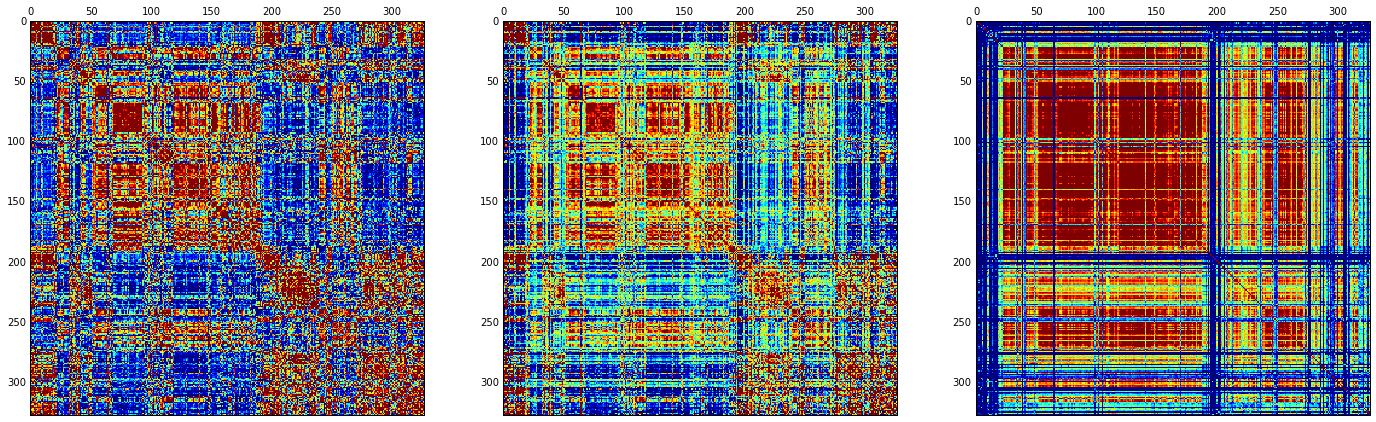

In [15]:
# mat = demean(cor_mat.fillna(0))
# mat = cor_mat
fig, axs = plt.subplots(1, 3, figsize = (24, 8))

axs[0].matshow(demean(stand(demean(cor_mat))), vmin = -10, vmax = 10)
axs[1].matshow(demean(cor_mat), vmin = -.1, vmax = .1)
axs[2].matshow(cor_mat.fillna(0), vmin = .2, vmax = .7)

# plt.hist(stand(demean(cor_mat)).std(), 30)
# plt.show()

In [16]:
# Try spectral clustering. Works when matrix is demeaned
from sklearn.cluster import SpectralClustering

X_ = demean(cor_mat)
# X_ = demean(stand(demean(cor_mat)))

clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0).fit(X_.values)

pd.options.display.max_rows = 500
clust_result = pd.DataFrame(clustering.labels_, index = X.columns, columns = ['cluster'])
clust_result = pd.concat([clust_result, industry_titles.set_index('industry_code')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'industry_title'])

/home/miglesia/anaconda2/lib/python2.7/site-packages/sklearn/cluster/spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


In [17]:
edges = pd.DataFrame(demean(cor_mat).stack(), columns = ['dem_corr'])
# edges = pd.DataFrame(demean(stand(demean(cor_mat))).stack(), columns = ['dem_corr'])
# > demean(cor_mat).values, 90
# edges.loc[]
edges_s = edges.loc[edges.dem_corr > edges.dem_corr.quantile(.925)]
edges_s.index.names = ['industry_code_x', 'industry_code_y']
edges_s = edges_s.reset_index().merge(
    industry_titles, left_on = 'industry_code_x', right_on = 'industry_code').merge(
    industry_titles, left_on = 'industry_code_y', right_on = 'industry_code').T.drop_duplicates().T
edges_s['dem_corr'] = edges_s['dem_corr'].astype(float)

In [18]:
# #Load modules
# from numpy.random import choice 
# from numpy import where, power

In [19]:
import matplotlib.colors as mcolors

# nodes = industry_titles

nodes_size = pd.DataFrame(np.sqrt(X.sum()), columns=['sqrt_size'])
nodes = pd.concat([nodes_size, clust_result], axis = 1, sort = False)

norm = mcolors.Normalize(vmin=0, vmax=10, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.gist_ncar)

nodes['color'] = nodes['cluster'].apply(lambda x: mcolors.rgb2hex(mapper.to_rgba(x)))

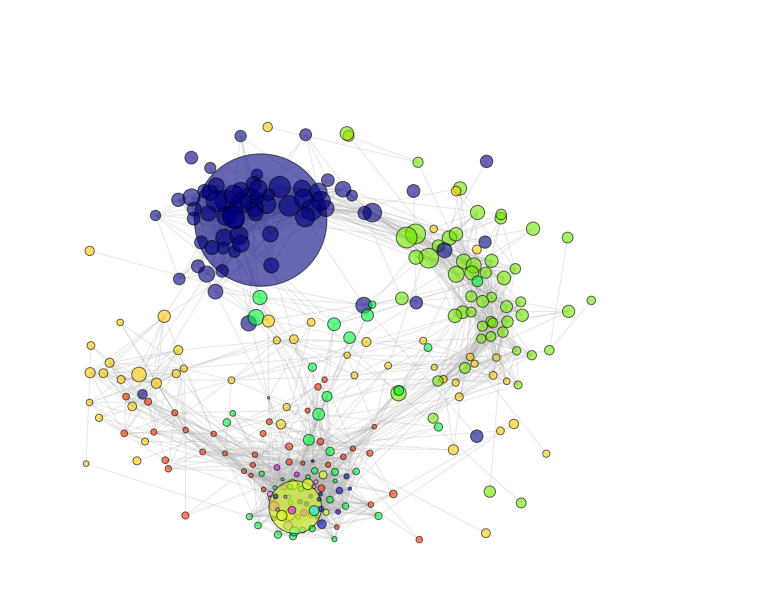

In [66]:
max_d = 40
weight_column = 'dem_corr' #'weight_'+geo

        ### Max degree = max_d. Parameter used to trim the network.
df1 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
df2 = edges_s.groupby('industry_code_y').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
edges_max_d = df1.merge(df2, on = ['industry_code_x', 'industry_title_x', 'industry_code_y', 'industry_title_x', weight_column]).reset_index(drop = True)

###

# Hard threshold and max degree backboning

G = nx.from_pandas_edgelist(edges_max_d, 'industry_code_x', 'industry_code_y', weight_column)


plt.figure(figsize = (10, 8))

G = max(nx.connected_component_subgraphs(G), key=len)
nodes_s = nodes.loc[G.nodes.keys()]
pos = nx.spring_layout(G, k=.35)

nx.draw(G, pos, node_size = nodes_s.sqrt_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
# plt.title('max_d = '+str(max_d))
#     plt.savefig('./Figures/5_max_deg/'+col_name+'_plot1.png')
#             plt.show()

plt.show()

### Draw in d3plus

In [67]:
# nodes
pos_df = pd.DataFrame(pos, index = ['x', 'y']).T
nodes_wpos = pd.concat([nodes_s, pos_df], axis = 1, sort = False)

In [68]:
nodes_ = nodes_wpos.reset_index()[['index','x', 'y', 'industry_title', 'color']].dropna(subset = ['x']).rename({'index': 'id'}, axis = 1)
nodes_['id'] = nodes_['id'].astype(str).str.zfill(4)
nodes_[['x', 'y']] = 500 * nodes_[['x', 'y']]


In [69]:
nodes_.head()

,id,x,y,industry_title,color
0,1142,-13.205838,-270.231036,NAICS 1142 Hunting and trapping,#ec84ef
1,5173,361.534266,4.721834,NAICS 5173 Wired and wireless telecommunications carriers,#74e800
2,5171,288.556532,-291.286594,NAICS12 5171 Wired telecommunications carriers,#74e800
3,1141,11.198593,-308.713694,NAICS 1141 Fishing,#00fd3f
4,3335,-290.241253,-56.084744,NAICS 3335 Metalworking machinery manufacturing,#ffce05


In [70]:
# nodes_.sort_values(by = 'id')#.loc[nodes_.id == 'Desert']

In [71]:
import sys
sys.path.append("./../Hidalgo_Haussmann") # for HH tools
import pandas as pd
from HH_tools import robust_proximity, year_to_tp, RCA

In [72]:
nodes_['presence'] = True

edges_max_d['edge_tuple'] = list(zip(edges_max_d.industry_code_x, edges_max_d.industry_code_y))
edges_max_d['edge_tuple_rev'] = list(zip(edges_max_d.industry_code_y, edges_max_d.industry_code_x))
edges_max_d_triangles = edges_max_d.loc[edges_max_d.edge_tuple.isin(G.edges()) | edges_max_d.edge_tuple_rev.isin(G.edges())]

links = edges_max_d_triangles.reset_index().rename({weight_column: 'strength'},axis = 1)
links['target'] = links['industry_code_y'].astype(str).str.zfill(4)
links['source'] = links['industry_code_x'].astype(str).str.zfill(4)

# links = nc_backbone.reset_index().rename({'score': 'strength'},axis = 1)
# links['target'] = links['trg'].astype(str).str.zfill(4)
# links['source'] = links['src'].astype(str).str.zfill(4)

network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'
# network

In [73]:
## Conditional coloring

# Manufacturing (light_blue) and services (yellow)
nodes_['color_mfg_srv'] = 'D3D3D3' #Gray bckg

conditions = [
    (nodes_['industry_title'].str.lower().str.contains('manufacturing')) + (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('service')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('wholesale')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (-nodes_['industry_title'].str.lower().str.contains('naics'))]

choices = ['#000080', '#ffc400', '#00b0ff', '#000000']

nodes_['color_mfg_srv'] = np.select(conditions, choices, default='#D3D3D3')


In [74]:
edges_max_d_triangles.to_csv('edges_max_d_triangles.csv', index = False)

In [75]:
nodes_.dropna().shape

(289, 7)

In [76]:
ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color="color_mfg_srv",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

<IPython.core.display.Javascript object>

In [77]:
ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color="color",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

<IPython.core.display.Javascript object>

In [59]:
nodes.groupby('cluster').color.unique()

cluster
0.0    [#000080]
1.0    [#000ecd]
2.0    [#00edff]
3.0    [#00fd3f]
4.0    [#74e800]
5.0    [#dbff20]
6.0    [#ffce05]
7.0    [#ff3400]
8.0    [#f107ff]
9.0    [#ec84ef]
Name: color, dtype: object

### Activities by cluster

In [60]:

nodes.to_csv('./../data/naics_cluster_color.csv')

In [61]:
# Save total establishments by spectral analysis cluster, and county:
# xx
X_area_cluster = pd.concat([nodes[['cluster']], X.T], axis = 1)
X_area_cluster = X_area_cluster.iloc[10:]
X_area_cluster = X_area_cluster.groupby('cluster').sum().T
X_area_cluster.to_csv('./data/X_county_cluster.csv')

X_area_cluster.head()

cluster,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0
01001,578.950000,0.6,0.000000,54.450000,71.566667,5.6,33.233333,3.633333,4.4,0.000000
01003,3448.400000,20.0,1.800000,155.950000,569.783333,16.0,205.666667,18.150000,12.9,1.666667
01005,370.050000,5.2,1.000000,56.600000,47.200000,2.4,34.416667,4.200000,16.8,1.800000
01007,175.966667,0.0,0.333333,40.433333,22.150000,1.2,28.850000,0.666667,16.2,1.600000
01009,493.350000,0.0,0.000000,66.550000,61.616667,3.4,56.383333,5.633333,4.4,0.000000


In [62]:
# X.T.iloc[10:].sum().sum()/1e6

In [63]:
clusters = nodes.loc[nodes.industry_title.str.contains('NAICS')].reset_index().rename(columns = {'index': 'industry_code'})[['industry_code', 'industry_title', 'cluster', 'color']]
clusters.to_csv('./data/clusters.csv', index = False)

In [64]:
pd.set_option('display.max_colwidth', -1)
summary = nodes.loc[nodes.industry_title.str.contains('NAICS')].groupby('cluster').apply(lambda x: x.sample(3))#.agg({'industry_title': 'first', 'color':[ 'first', 'count']})
# summary.columns = ['color', 'node_count','example']
summary.sort_index()#.sort_values(by = 'node_count')

sqrt_size  cluster  \
cluster                             
0.0     4412  124.446575  0.0       
        5322  174.157017  0.0       
        8139  239.021931  0.0       
1.0     3117  28.724554   1.0       
        3151  23.481553   1.0       
        3161  15.442906   1.0       
2.0     2111  83.667198   2.0       
        3365  15.475788   2.0       
        4862  33.399102   2.0       
3.0     3114  41.110826   3.0       
        4854  68.440729   3.0       
        9221  162.472664  3.0       
4.0     5324  101.250844  4.0       
        5511  201.453675  4.0       
        6219  89.048208   4.0       
5.0     1112  64.691834   5.0       
        1119  105.039278  5.0       
        1125  25.565602   5.0       
6.0     3219  97.785565   6.0       
        4855  34.753417   6.0       
        9281  55.876948   6.0       
7.0     3115  38.513634   7.0       
        3241  45.712690   7.0       
        4851  30.321884   7.0       
8.0     1133  95.919063   8.0       
        2121  32.301187   8.0       
        3211  59.307672   8.0       
9.0     1111  76.346687   9.0       
        1142  17.839563   9.0       
        2122  16.407823   9.0       

                                                       industry_title    color  
cluster                                                                         
0.0     4412  NAICS 4412 Other motor vehicle dealers                   #000080  
        5322  NAICS 5322 Consumer goods rental                         #000080  
        8139  NAICS 8139 Professional and similar organizations        #000080  
1.0     3117  NAICS 3117 Seafood product preparation and packaging     #000ecd  
        3151  NAICS 3151 Apparel knitting mills                        #000ecd  
        3161  NAICS 3161 Leather and hide tanning and finishing        #000ecd  
2.0     2111  NAICS 2111 Oil and gas extraction                        #00edff  
        3365  NAICS 3365 Railroad rolling stock manufacturing          #00edff  
        4862  NAICS 4862 Pipeline transportation of natural gas        #00edff  
3.0     3114  NAICS 3114 Fruit and vegetable preserving and specialty  #00fd3f  
        4854  NAICS 4854 School and employee bus transportation        #00fd3f  
        9221  NAICS 9221 Justice, public order, and safety activities  #00fd3f  
4.0     5324  NAICS 5324 Machinery and equipment rental and leasing    #74e800  
        5511  NAICS 5511 Management of companies and enterprises       #74e800  
        6219  NAICS 6219 Other ambulatory health care services         #74e800  
5.0     1112  NAICS 1112 Vegetable and melon farming                   #dbff20  
        1119  NAICS 1119 Other crop farming                            #dbff20  
        1125  NAICS 1125 Aquaculture                                   #dbff20  
6.0     3219  NAICS 3219 Other wood product manufacturing              #ffce05  
        4855  NAICS 4855 Charter bus industry                          #ffce05  
        9281  NAICS 9281 National security and international affairs   #ffce05  
7.0     3115  NAICS 3115 Dairy product manufacturing                   #ff3400  
        3241  NAICS 3241 Petroleum and coal products manufacturing     #ff3400  
        4851  NAICS 4851 Urban transit systems                         #ff3400  
8.0     1133  NAICS 1133 Logging                                       #f107ff  
        2121  NAICS 2121 Coal mining                                   #f107ff  
        3211  NAICS 3211 Sawmills and wood preservation                #f107ff  
9.0     1111  NAICS 1111 Oilseed and grain farming                     #ec84ef  
        1142  NAICS 1142 Hunting and trapping                          #ec84ef  
        2122  NAICS 2122 Metal ore mining                              #ec84ef

In [38]:
nodes_['color'].value_counts().index

Index([u'#000080', u'#74e800', u'#ffce05', u'#ff3400', u'#00fd3f', u'#000ecd',
       u'#dbff20', u'#ec84ef', u'#00edff', u'#f107ff'],
      dtype='object')

In [39]:
# land-use clusters
nodes_.loc[nodes_['color'].isin(['#f10800', '#ff6800', '#ceff29', '#29ffce'])].sort_values(by = ['color','industry_title'])

#population cluster
nodes_.loc[nodes_['color'].isin(['#7dff7a'])].sort_values(by = ['color','industry_title'])

#'yellow' services cluster
nodes_.loc[nodes_['color'].isin(['#ffc400'])].sort_values(by = ['color','industry_title'])

#state/public sector cluster
# nodes_.loc[nodes_['color'].isin(['#004cff'])].sort_values(by = ['color','industry_title'])

#others/mfg clusters
# nodes_.loc[nodes_['color'].isin(['#000080', '#0000f1', '#00b0ff'])].sort_values(by = ['industry_title'])

# coastal?
# nodes_.loc[nodes_['color'].isin(['#0000f1'])].sort_values(by = ['color','industry_title'])

,id,x,y,industry_title,color,presence,color_mfg_srv


### Keywords by cluster

In [40]:
# Cluster 7, #ffc400 are 76 nodes that follow neither population nor land resources. Then what is it all about?
from collections import Counter
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

from IPython.display import display, HTML
import colorlover as cl    
    
for clsr in range(10):
    try:
        
        text = nodes.loc[nodes.cluster == clsr]['industry_title']

        r1 = text.str.lower().str.split().values
        r1 = [item for sublist in r1 for item in sublist]

        r1_f = [w.replace(',', '').replace('mfg.', 'manufacturing') for w in r1 if not w in stop_words] 

        print(summary.loc[clsr])
        color = summary.loc[clsr]['color']
        display(HTML(cl.to_html( [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))] )))
        print(Counter(r1_f).most_common()[:10])
        print('\n')
    except:
        pass

       sqrt_size  cluster  \
2382  435.546764  0.0       
4532  213.303579  0.0       
4411  223.086717  0.0       

                                               industry_title    color  
2382  NAICS 2382 Building equipment contractors                #000080  
4532  NAICS 4532 Office supplies, stationery, and gift stores  #000080  
4411  NAICS 4411 Automobile dealers                            #000080  
      sqrt_size  cluster                          industry_title    color
4832  22.627049  1.0      NAICS 4832 Inland water transportation  #000ecd
3162  16.234736  1.0      NAICS 3162 Footwear manufacturing       #000ecd
3151  23.481553  1.0      NAICS 3151 Apparel knitting mills       #000ecd
      sqrt_size  cluster                                     industry_title  \
4862  33.399102  2.0      NAICS 4862 Pipeline transportation of natural gas   
2111  83.667198  2.0      NAICS 2111 Oil and gas extraction                   
2131  99.456942  2.0      NAICS 2131 Support activities fo

### Map distribution from different clusters

In [41]:
# nodes
import geopandas as gpd

counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP


In [42]:
### A little trick. Distribution of neigbors of node 'Naics 5417 Scientific Research and Development Services'
# nodes_.loc[nodes_.id == '5417']
ego_node = 'Desert' #'Cropland' #'POPESTIMATE2010'# '5417'

neigh = edges_max_d_triangles.loc[(edges_max_d_triangles.industry_code_x == ego_node) |
                                  (edges_max_d_triangles.industry_code_y == ego_node)]
neigh_ids = list(set(neigh['industry_code_x'].unique()).union(set(neigh['industry_code_y'].unique())))
# nodes_.loc[nodes_.id.isin(neigh_ids)]['id'].values

node_ids = neigh_ids

In [43]:
# gdf.loc[gdf.industry_code == naics]['annual_avg_estabs']
# df_neigh
# df_neigh.groupby('industry_code').mean().sort_values(by = 'annual_avg_estabs').tail(5).index

In [44]:
from PIL import Image, ImageDraw, ImageFont


In [45]:
# Choose indus to process...
n = 5
merged = df_agglv_yravg.groupby(level = 1)['annual_avg_estabs'].sum().reset_index().merge(nodes_, left_on = 'industry_code', right_on = 'id')
display_indus = merged.loc[merged.groupby('color')['annual_avg_estabs'].nlargest(n).index.get_level_values(1)]

#Filter original data to have these neighboring industries
df_agglv = df.loc[df.agglvl_code == 76]

df_agglv_yravg = df_agglv.groupby(['area_fips', 'industry_code']).mean().drop(['agglvl_code','year'], axis = 1)
# df_indu_prc_area = df_agglv_yravg.groupby(level=0).apply(lambda x: 100 * x / x.sum())
df_indu_prc_area = log10(df_agglv_yravg)

df_ = df_indu_prc_area.reset_index()

i = 0
open('./Figures/7_compo_USA_nw/labels.txt', 'w').close()
for color in nodes_.color.unique():
  
    cluster_ids = nodes_.loc[nodes_.color == color]['id']
    node_ids = cluster_ids.values
    
    df_neigh = df_.loc[df_.industry_code.isin(nodes_.loc[nodes_.id.isin(node_ids)]['id'].values)]
    df_neigh = df_neigh.set_index('area_fips')
    
    counties_ = counties.set_index('area_fips').reindex(df_neigh.index)[['geometry']]
    gdf = gpd.GeoDataFrame(pd.concat([df_neigh, counties_], axis = 1, sort = True).dropna())

    # Sample of cluster color
    rgb_tuple = tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))
    im = Image.new('RGBA', (20, 20), rgb_tuple)
    im.save('./Figures/7_compo_USA_nw/cp_'+str(i)+'.png')

    for naics in display_indus['industry_code'].values:
        if( gdf.loc[gdf.industry_code == naics]['annual_avg_estabs'].mean() > .2 ):#& (i <=5): # Dismiss small indus
            node_info = nodes_.loc[nodes_.id == naics]
            
            # send node labels to test (they will then go to svg of figure)
            with open('./Figures/7_compo_USA_nw/labels.txt', 'a') as f:
                f.write(node_info['industry_title'].values[0]+'\n')
            display(node_info)
            display(HTML(cl.to_html( [rgb_tuple] )))

            ax = gdf.loc[gdf.industry_code == naics].plot(
                column='annual_avg_estabs', cmap=plt.cm.gist_yarg, vmin = 0, vmax = 1.5, linewidth = 0, figsize = (10, 6.5))
            ax.set_xlim(-130, -60)
            ax.set_ylim(22, 50)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
#             plt.axis('off')
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            plt.text(-128, 23.5, 'NAICS '+str(node_info['id'].values[0]), fontsize=30) # position in lat lon
            plt.savefig('./Figures/7_compo_USA_nw/'+str(node_info['id'].values[0])+'.png', bbox_inches = 'tight')
            plt.show()
    i+=1

NameError: name 'df_agglv_yravg' is not defined

In [ ]:
# TXT2InkscapeXMLv3.py

# A simple Python 3 script to look through a list of text and
# turn each line into an xml entry for use in Inkscape.
# in this script we will slightly spread the text to allow
# the user a better chance of retaining the order of their
# initial text.  Inkscape can be used to spread it out
# using the Align and Distribute Tool.


ofilenm = './Figures/7_compo_USA_nw/figure.svg'#str(input("What is the filename you wish for output?"))
outfile = open(ofilenm,"w")

ListFlm = './Figures/7_compo_USA_nw/labels.txt'#str(input("What is the name and location of the TXT file to work with?"))

Loctn = 75 #Vertical position to start text insertion
SpacingV = 25  #The vertical spacing between lines.

# The block that follows is the Inkscape standard header.
TextBlockA = '''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   xmlns:dc="http://purl.org/dc/elements/1.1/"
   xmlns:cc="http://creativecommons.org/ns#"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:svg="http://www.w3.org/2000/svg"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   width="744.09448819"
   height="1052.3622047"
   id="svg2"
   version="1.1"
   inkscape:version="0.48.4 r9939"
   sodipodi:docname="New document 1">
  <defs
     id="defs4" />
  <sodipodi:namedview
     id="base"
     pagecolor="#ffffff"
     bordercolor="#666666"
     borderopacity="1.0"
     inkscape:pageopacity="0.0"
     inkscape:pageshadow="2"
     inkscape:zoom="0.35"
     inkscape:cx="375"
     inkscape:cy="520"
     inkscape:document-units="px"
     inkscape:current-layer="layer1"
     showgrid="false"
     inkscape:window-width="1280"
     inkscape:window-height="742"
     inkscape:window-x="-2"
     inkscape:window-y="-3"
     inkscape:window-maximized="1" />
  <metadata
     id="metadata7">
    <rdf:RDF>
      <cc:Work
         rdf:about="">
        <dc:format>image/svg+xml</dc:format>
        <dc:type
           rdf:resource="http://purl.org/dc/dcmitype/StillImage" />
        <dc:title></dc:title>
      </cc:Work>
    </rdf:RDF>
  </metadata>
  <g
     inkscape:label="Layer 1"
     inkscape:groupmode="layer"
     id="layer1">'''

TextBlockB = '''<text\n
        xml:space="preserve"
        style="font-size:20px;font-style:normal;font-weight:normal;line-height:125%;letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;font-family:Sans"
        x="93.910118"
        y="'''
TextBlockC = '''id="text2989"
        sodipodi:linespacing="150%"><tspan
            sodipodi:role="line"
            id="tspan2991"
            x="93.910118"
            y="'''

outfile.write(TextBlockA)

# The section that follows is to build the SVG text elements
f = open(ListFlm,"r")
for line in f:
    TXTLine = line.strip()
    Loctn = Loctn + SpacingV
    InsertStrng1 = str(Loctn)+'"\n'
    InsertStrng2= str(Loctn)+'">'+TXTLine+'</tspan></text>\n'
    outfile.write(TextBlockB)
    outfile.write(InsertStrng1)
    outfile.write(TextBlockC)
    outfile.write(InsertStrng2)

# The next section is the close off for the SVG xml.

outfile.write('  </g>\n')
outfile.write('</svg>\n')

outfile.close()
print("Done")

In [ ]:
# Choose indus to process...
n = 5
merged = df_agglv_yravg.groupby(level = 1)['annual_avg_estabs'].sum().reset_index().merge(nodes_, left_on = 'industry_code', right_on = 'id')
display_indus = merged.loc[merged.groupby('color')['annual_avg_estabs'].nlargest(n).index.get_level_values(1)]

#Filter original data to have these neighboring industries
df_agglv = df.loc[df.agglvl_code == 76]

df_agglv_yravg = df_agglv.groupby(['area_fips', 'industry_code']).mean().drop(['agglvl_code','year'], axis = 1)
# df_indu_prc_area = df_agglv_yravg.groupby(level=0).apply(lambda x: 100 * x / x.sum())
df_indu_prc_area = log10(df_agglv_yravg)

df_ = df_indu_prc_area.reset_index()

for color in nodes_.color.unique():
  
    cluster_ids = nodes_.loc[nodes_.color == color]['id']
    node_ids = cluster_ids.values
    
    df_neigh = df_.loc[df_.industry_code.isin(nodes_.loc[nodes_.id.isin(node_ids)]['id'].values)]
    df_neigh = df_neigh.set_index('area_fips')
    
    counties_ = counties.set_index('area_fips').reindex(df_neigh.index)[['geometry']]
    gdf = gpd.GeoDataFrame(pd.concat([df_neigh, counties_], axis = 1, sort = True).dropna())
    
    for naics in display_indus['industry_code'].values:
        if( gdf.loc[gdf.industry_code == naics]['annual_avg_estabs'].mean() > .45 ):#& (i <=5): # Dismiss small indus
            display(nodes_.loc[nodes_.id == naics])
            display(HTML(cl.to_html( [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))] )))

            ax = gdf.loc[gdf.industry_code == naics].plot(
                column='annual_avg_estabs', cmap=plt.cm.gist_yarg, vmin = 0, vmax = 1.5, linewidth = 0, figsize = (10, 6.5))
            ax.set_xlim(-130, -60)
            ax.set_ylim(22, 50)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
            plt.show()
            i+=1

### Color by Population Density

In [ ]:
processed_data_path = './../../../../../media/miglesia/Elements/corr_st_data/'

main_tables = pd.concat([pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2012_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2011.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2013.csv')])

main_table = main_tables.groupby('CHI ID COM').mean()/2.

# change node names into node index
# main_table.rename(columns = dict(zip(nodes.node_name, nodes.index)), inplace = True)

population = pd.read_csv('./data/pop_dist_comuna.csv').rename(columns = {'comuna_id': 'CHI ID COM'})

In [ ]:
from numpy import log10
population['log_dens'] = log10(population['densidad'])
b = 8; population['log_dens_cat'] = pd.cut(population['log_dens'], b)

bins = pd.cut(population['log_dens'], b, retbins=True)[1]
bins_mean = (bins[1:] + bins[:-1])/2.

merged = pd.concat([population.set_index('CHI ID COM')[['log_dens_cat']].sort_index(), main_table], axis = 1)
popdens_RCA = RCA(merged.groupby('log_dens_cat').sum())

popdens_RCA_normed = popdens_RCA/popdens_RCA.sum()

In [ ]:
nodes_

In [ ]:
# pop_dens_index = pd.DataFrame((popdens_RCA_normed.T*bins_mean).T.sum(), columns = ['pop_dens_index'])
# pop_dens_index = pop_dens_index.reset_index().rename(columns={'index':'id'})
# nodes_ = nodes_.merge(pop_dens_index, on = 'id', how = 'left') # industry_title / node_name
# # nodes_['pop_dens_color_code'] = pd.cut(nodes_['pop_dens_index'], bins = 7, labels=False)

# from numpy import nan
# rainbow_colors = {0:'#9400D3', #Violet
# 1:'#4B0082', #Indigo
# 2:'#0000FF', #Blue
# 3:'#00FF00', #Green
# nan:'#D3D3D3',  #'#D3D3D3', #Gray
# 4:'#FFFF00', #Yellow
# 5:'#FF7F00', #Orange
# 6:'#FF0000'} #Red

# nodes_['color_2'] = pd.DataFrame(nodes_['pop_dens_color_code'].map(rainbow_colors))

# network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'

In [ ]:
ps = d3plus.ProductSpace(
id="name",
name="node_name",
color="color_2",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

In [ ]:
plt.hist(edges.weight_CHI_COM.values, 50)
plt.hist(edges_max_d.weight_CHI_COM.values, 50)
plt.show()